Ejercicio 3: Segmentación por Color


Dada una imagen con objetos de diferentes colores:

a) Implementar una segmentación para extraer objetos de un color específico usando umbrales en los canales RGB.

b) Calcular y mostrar el histograma de la imagen en escala de grises.

c) Encontrar las coordenadas del rectángulo que encierra el objeto segmentado.

d) Dibujar los bordes del objeto segmentado en color rojo.

In [ ]:
# Segmentación Simple por Color

import urllib.request
import cv2
import numpy as np
from cv2 import imread, cvtColor, COLOR_BGR2RGB
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [ ]:
# Función para analizar características de la imagen
def info_img(img):
    print('tamaño =', img.shape)
    print('máximo =', np.max(img))
    print('mínimo =', np.min(img))


In [ ]:
# Función para segmentar automáticamente según el color dominante en RGB
def segmentacion_color_dominante(img_rgb, k=3):
    pixels = img_rgb.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pixels)
    centros = kmeans.cluster_centers_
    suma_rgb = centros.sum(axis=0)
    canal_dominante = np.argmax(suma_rgb)
    nombres = ['Rojo', 'Verde', 'Azul']
    print(f"Canal dominante detectado: {nombres[canal_dominante]}")
    umbral_min = np.min(centros[:, canal_dominante]) - 30
    umbral_max = np.max(centros[:, canal_dominante]) + 30
    umbral_min = np.clip(umbral_min, 0, 255)
    umbral_max = np.clip(umbral_max, 0, 255)
    R = img_rgb[:, :, 0]
    G = img_rgb[:, :, 1]
    B = img_rgb[:, :, 2]
    if canal_dominante == 0:
        seg = np.logical_and(R > umbral_min, R < umbral_max)
        seg = np.logical_and(seg, G < 100)
        seg = np.logical_and(seg, B < 100)
    elif canal_dominante == 1:
        seg = np.logical_and(G > umbral_min, G < umbral_max)
        seg = np.logical_and(seg, R < 100)
        seg = np.logical_and(seg, B < 100)
    else:
        seg = np.logical_and(B > umbral_min, B < umbral_max)
        seg = np.logical_and(seg, R < 100)
        seg = np.logical_and(seg, G < 100)
    return seg

In [ ]:
# Carga de imagen en BGR y comprobación
try:
    url = "https://upload.wikimedia.org/wikipedia/commons/5/5a/D%C3%BClmen%2C_Fr%C3%B6belstra%C3%9Fe%2C_Mohn_am_Feldrand_--_2021_--_9174.jpg"
    resp = urllib.request.urlopen(url)
    imagen_bgr = np.asarray(bytearray(resp.read()), dtype="uint8")
    imagen_bgr = cv2.imdecode(imagen_bgr, cv2.IMREAD_COLOR)
    cv2_imshow(imagen_bgr)
    info_img(imagen_bgr)

except urllib.error.URLError as e:
    print(f"Error al descargar la imagen: {e}")


Output hidden; open in https://colab.research.google.com to view.

## Redimensión de la imagen para una mejor visualización y proceso

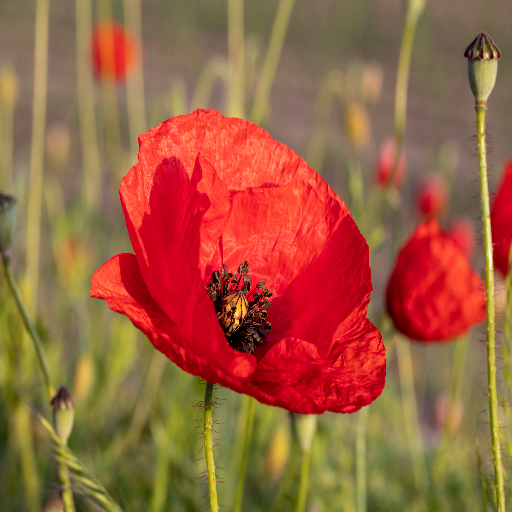

tamaño = (512, 512, 3)
máximo = 255
mínimo = 0


In [ ]:
imagen_bgr = cv2.resize(imagen_bgr, (512, 512))
cv2_imshow(imagen_bgr)
info_img(imagen_bgr)

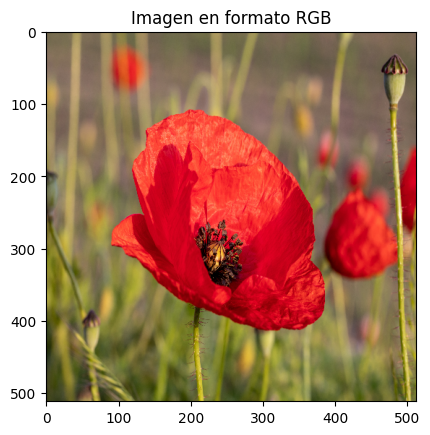

tamaño = (512, 512, 3)
máximo = 255
mínimo = 0


In [ ]:
# Conversión BGR a RGB
img_rgb = cvtColor(imagen_bgr, COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Imagen en formato RGB')
plt.show()
info_img(imagen_bgr)

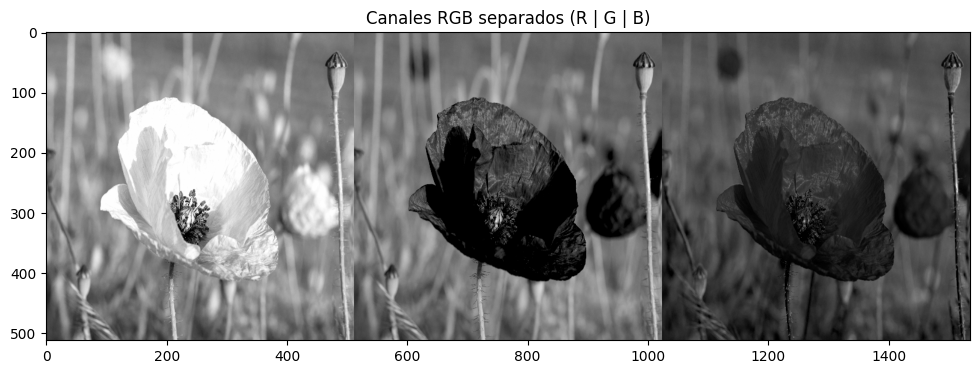

In [ ]:
# Separación de canales de color
rojo = img_rgb[:,:,0]
verde = img_rgb[:,:,1]
azul = img_rgb[:,:,2]
canales = np.concatenate((rojo,verde,azul),axis=1)
plt.figure(figsize=(12, 4))
plt.imshow(canales, cmap='gray')
plt.title('Canales RGB separados (R | G | B)')
plt.show()

# Conversión a escala de grises
rojo_f = rojo.astype(float)
verde_f = verde.astype(float)
azul_f = azul.astype(float)

Pesos para percepción humana (0.299, 0.587, 0.114):

Este método, conocido como la fórmula de luminancia, está basado en la sensibilidad del ojo humano.
El ojo humano es más sensible al verde, menos al rojo, y mucho menos al azul.
Los pesos están calibrados según la respuesta del sistema visual humano.

Fórmula: gris = 0.299 * R + 0.587 * G + 0.114*B

La diferencia visual es que las imágenes convertidas con los pesos de percepción humana se ven más naturales y preservan mejor los detalles que son importantes para nuestra visión.
Para el ejercicio de segmentación, usar los pesos de percepción humana puede proporcionar una escala de grises que preserva mejor los contrastes importantes para la detección de bordes y características.

tamaño = (512, 512)
máximo = 254
mínimo = 0


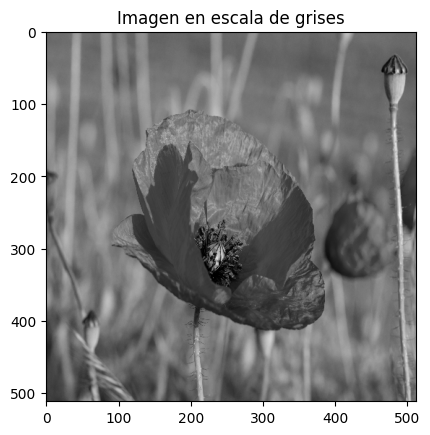

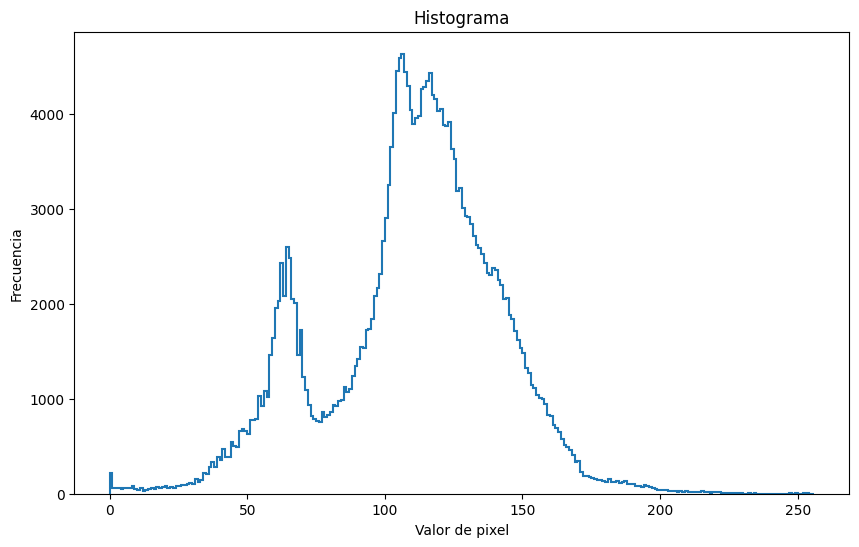

In [ ]:
# Promedio ponderado estándar para percepción humana
peso = (0.299, 0.587, 0.114)  # Pesos estándar para mejor percepción
gris_f = peso[0]*rojo_f + peso[1]*verde_f + peso[2]*azul_f
gris = gris_f.astype(np.uint8)  # Usar uint8 para mantener rango 0-255
info_img(gris)
plt.imshow(gris,cmap='gray')
plt.title('Imagen en escala de grises')
plt.show()

# Función para mostrar histograma
def histograma(X):
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(X.flatten(), bins=256,
                       range=[0, 256], histtype='step', linewidth=1.5)
    plt.title('Histograma')
    plt.xlabel('Valor de pixel')
    plt.ylabel('Frecuencia')
    plt.grid(False)
    plt.show()

histograma(gris)

Canal dominante detectado: Rojo


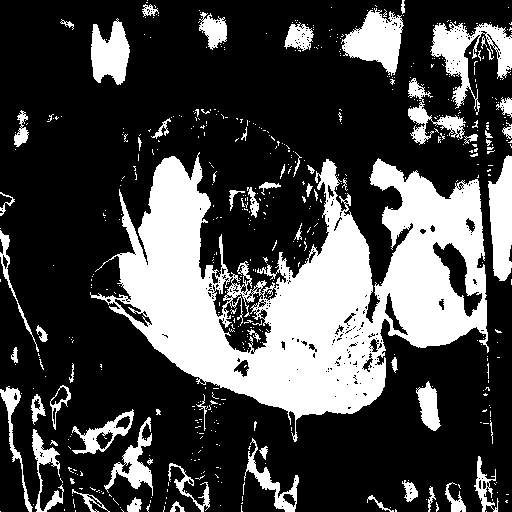

In [ ]:
# Segmentación automática por color dominante
seg = segmentacion_color_dominante(img_rgb)
cv2_imshow(seg.astype(np.uint8)*255)

In [ ]:
# Convertir de bool a uint8
seg_uint8 = (seg.astype(np.uint8)) * 255  # 0 o 255

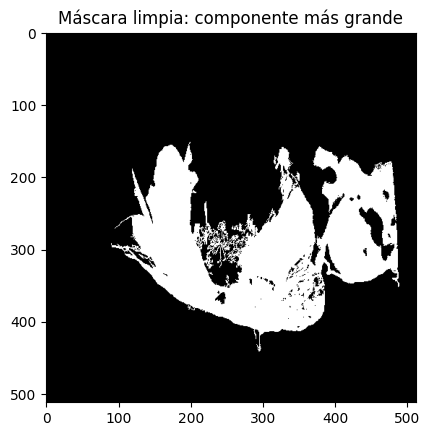

In [ ]:
(N, M) = seg_uint8.shape

# --- Limpieza usando componentes conectados ---
# Asegurarse que la máscara sea binaria (0 y 255)
_, binary_mask = cv2.threshold(seg_uint8, 0, 255, cv2.THRESH_BINARY)

# Buscar componentes conectados
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask)

# stats[1:, 4] son las áreas de cada componente (ignoramos el fondo [0])
areas = stats[1:, cv2.CC_STAT_AREA]
max_idx = 1 + np.argmax(areas)  # Índice del componente más grande (no fondo)

# Crear nueva máscara solo con el objeto más grande
limpia = np.where(labels == max_idx, 255, 0).astype(np.uint8)

# Mostrar máscara limpia
plt.imshow(limpia, cmap='gray')
plt.title('Máscara limpia: componente más grande')
plt.show()


Coordenadas del rectángulo:
Superior izquierda: (90, 152)
Superior derecha: (488, 152)
Inferior izquierda: (90, 441)
Inferior derecha: (488, 441)


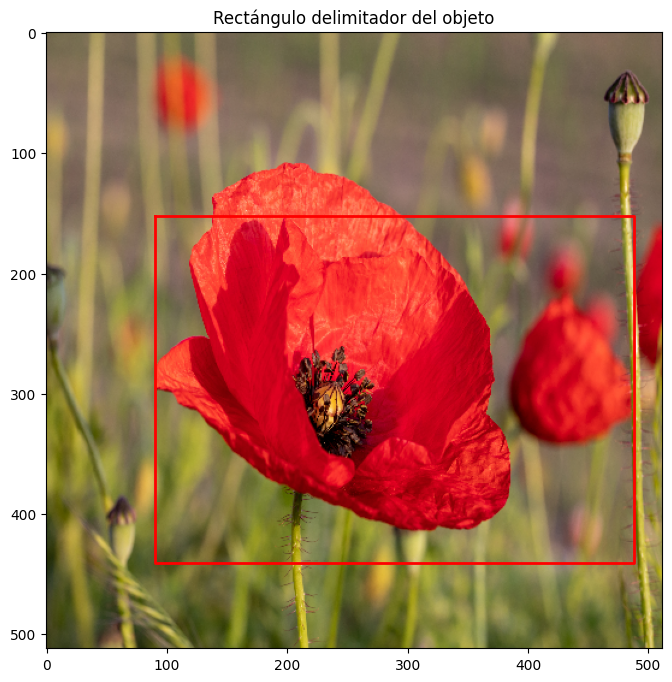

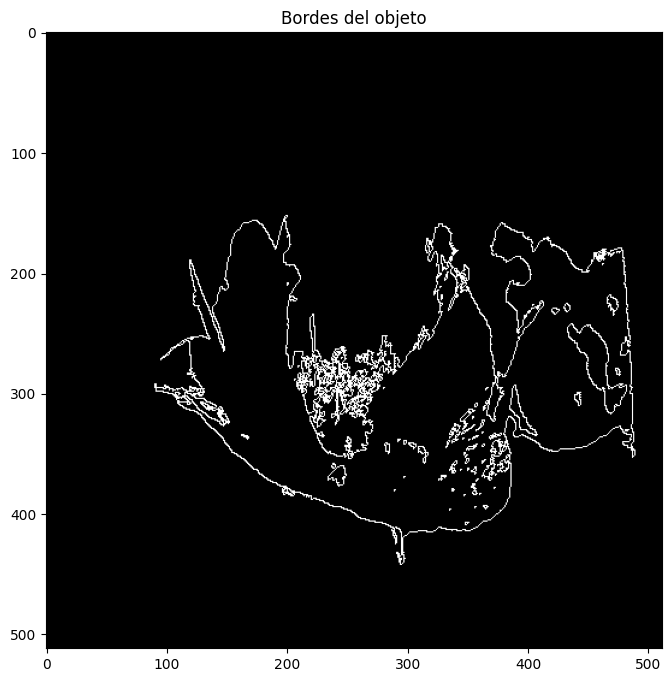

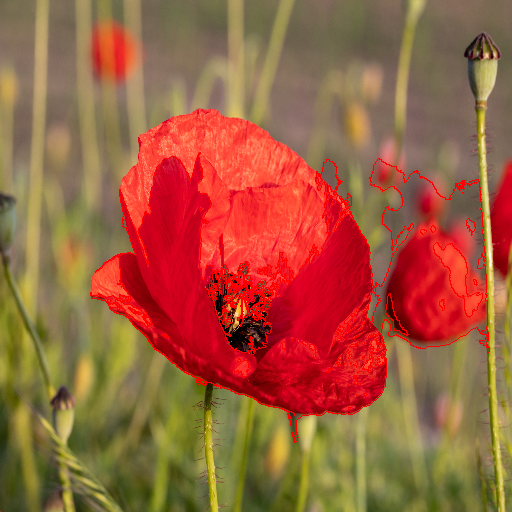

Imagen final con bordes del objeto destacados en rojo.


In [ ]:
# --- Búsqueda de coordenadas del rectángulo ---
i_min = N
i_max = 0
j_min = M
j_max = 0

for i in range(N):
    for j in range(M):
        if limpia[i,j] > 0:
            if i < i_min: i_min = i
            if i > i_max: i_max = i
            if j < j_min: j_min = j
            if j > j_max: j_max = j

print(f"Coordenadas del rectángulo:")
print(f"Superior izquierda: ({j_min}, {i_min})")
print(f"Superior derecha: ({j_max}, {i_min})")
print(f"Inferior izquierda: ({j_min}, {i_max})")
print(f"Inferior derecha: ({j_max}, {i_max})")

if i_min == N or j_min == M or i_max == 0 or j_max == 0:
    print("¡ADVERTENCIA! No se detectaron coordenadas válidas para el objeto.")
else:
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    y = [i_min, i_min, i_max, i_max, i_min]
    x = [j_min, j_max, j_max, j_min, j_min]
    plt.plot(x, y, 'r-', linewidth=2)
    plt.title('Rectángulo delimitador del objeto')
    plt.show()

    # --- Detección de bordes ---
    borde = np.zeros((N, M), np.uint8)

    for i in range(N):
        for j in range(1, M):
            if limpia[i,j] != limpia[i,j-1]:
                borde[i,j] = 1

    for i in range(1, N):
        for j in range(M):
            if limpia[i-1,j] != limpia[i,j]:
                borde[i,j] = 1

    plt.figure(figsize=(8, 8))
    plt.imshow(borde, cmap='gray')
    plt.title('Bordes del objeto')
    plt.show()

    # --- Dibujo final sobre la imagen original (BGR) ---
    img_final = imagen_bgr.copy()
    for i in range(N):
        for j in range(M):
            if borde[i,j] == 1:
                img_final[i,j] = [0, 0, 255]  # Rojo en BGR

    from google.colab.patches import cv2_imshow  # Solo si estás en Colab
    cv2_imshow(img_final)
    print("Imagen final con bordes del objeto destacados en rojo.")


# Opción usada en clase

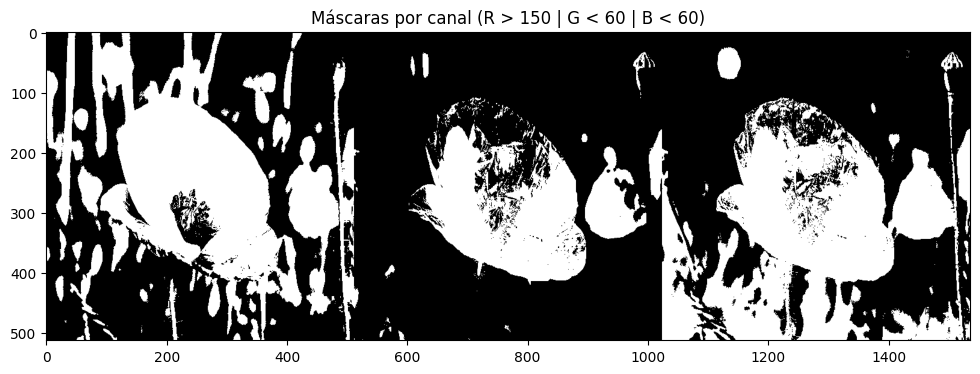

In [ ]:

# Segmentación de la flor roja - Ajustando umbrales para mejorar la detección
# Los valores para la flor roja: alto en rojo, bajo en verde y azul
seg_r = rojo > 150  # Umbral para canal rojo
seg_v = verde < 60  # Aumentando un poco el umbral del verde
seg_a = azul < 60   # Aumentando un poco el umbral del azul

# Visualizar máscaras por separado
seg_rgb = np.concatenate((seg_r, seg_v, seg_a), axis=1)
plt.figure(figsize=(12, 4))
plt.imshow(seg_rgb, cmap='gray')
plt.title('Máscaras por canal (R > 150 | G < 60 | B < 60)')
plt.show()


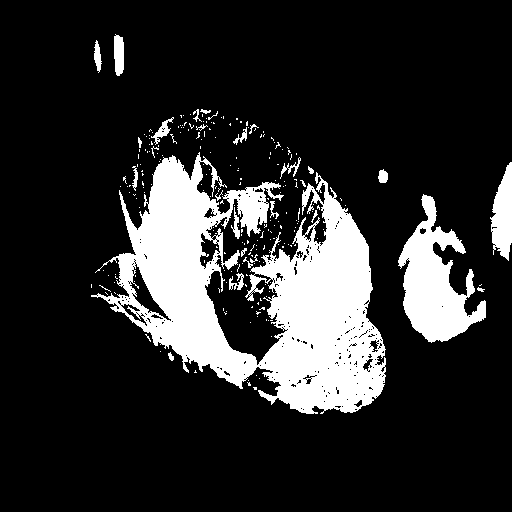

In [ ]:
# Combinar las tres condiciones para obtener la segmentación final
seg_rv = np.logical_and(seg_r, seg_v)  # Rojo alto y verde bajo
seg = np.logical_and(seg_rv, seg_a)    # Y también azul bajo
cv2_imshow(seg*255)



##ejecutar

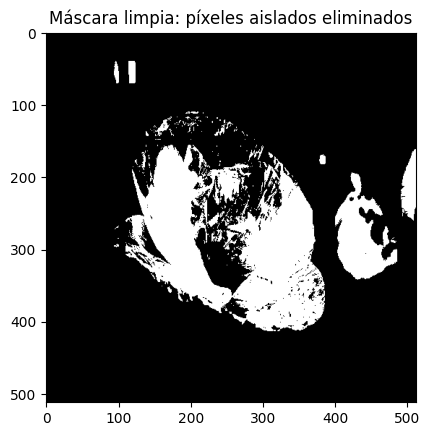

Coordenadas del rectángulo:
Superior izquierda: (94, 40)
Superior derecha: (511, 40)
Inferior izquierda: (94, 413)
Inferior derecha: (511, 413)


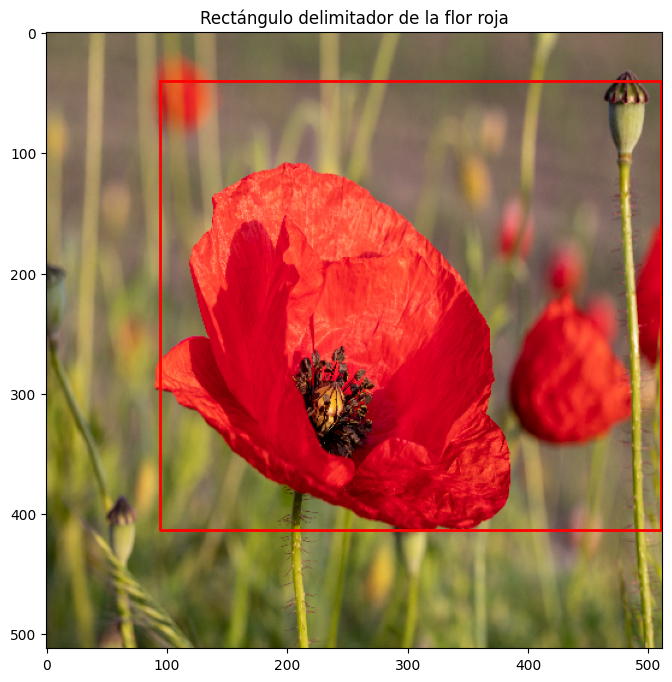

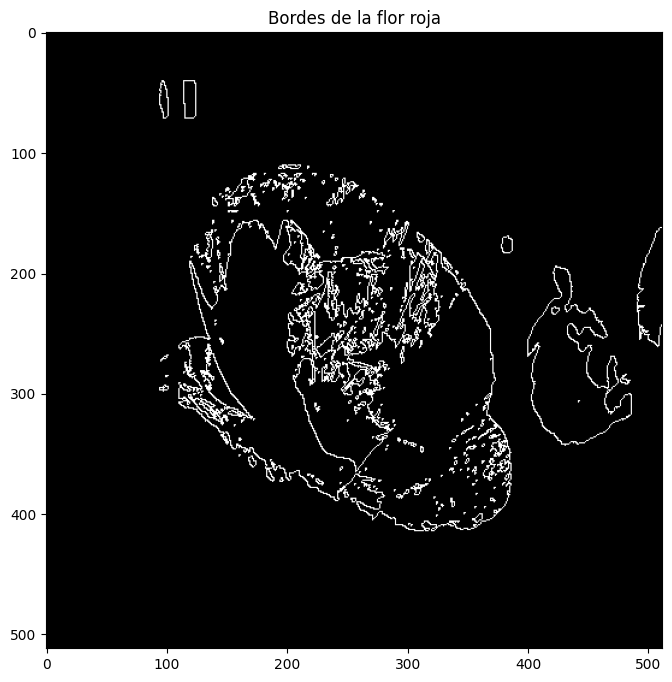

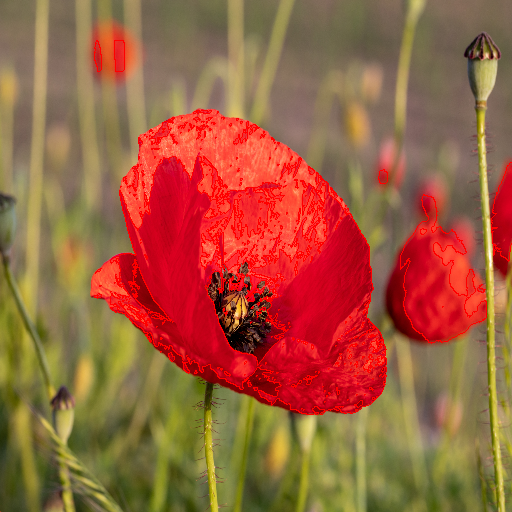

Imagen final con bordes de la flor roja destacados


In [ ]:
# Eliminación de píxeles aislados y limpieza mejorada
(N, M) = seg.shape
limpia = seg.copy()

# Limpieza por filas - eliminar filas con pocos píxeles
for i in range(N):
    s = np.sum(seg[i,:])
    if s < 10:  # Umbral para eliminar filas con pocos píxeles
        limpia[i,:] = 0

# Limpieza por columnas - eliminar columnas con pocos píxeles
for j in range(M):
    s = np.sum(seg[:,j])
    if s < 10:  # Umbral para eliminar columnas con pocos píxeles
        limpia[:,j] = 0

plt.imshow(limpia, cmap='gray')
plt.title('Máscara limpia: píxeles aislados eliminados')
plt.show()

# Búsqueda de coordenadas del rectángulo - inicializar correctamente
i_min = N  # Inicializar con el valor máximo posible
i_max = 0
j_min = M  # Inicializar con el valor máximo posible
j_max = 0

# Buscar los límites reales del objeto segmentado
for i in range(N):
    for j in range(M):
        if limpia[i,j] > 0:
            if i < i_min: i_min = i
            if i > i_max: i_max = i
            if j < j_min: j_min = j
            if j > j_max: j_max = j

print(f"Coordenadas del rectángulo:")
print(f"Superior izquierda: ({j_min}, {i_min})")
print(f"Superior derecha: ({j_max}, {i_min})")
print(f"Inferior izquierda: ({j_min}, {i_max})")
print(f"Inferior derecha: ({j_max}, {i_max})")

# Verificar que se encontraron coordenadas válidas
if i_min == N or j_min == M or i_max == 0 or j_max == 0:
    print("¡ADVERTENCIA! No se detectaron coordenadas válidas para el objeto rojo.")
    # En este caso, podrías asignar valores predeterminados o detener el proceso
else:
    # Dibujo del rectángulo
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    y = [i_min, i_min, i_max, i_max, i_min]
    x = [j_min, j_max, j_max, j_min, j_min]
    plt.plot(x, y, 'r-', linewidth=2)
    plt.title('Rectángulo delimitador de la flor roja')
    plt.show()

    # Detección de bordes mejorada
    borde = np.zeros((N, M), np.uint8)

    # Bordes horizontales
    for i in range(N):
        for j in range(1, M):
            if limpia[i,j] != limpia[i,j-1]:
                borde[i,j] = 1

    # Bordes verticales
    for i in range(1, N):
        for j in range(M):
            if limpia[i-1,j] != limpia[i,j]:
                borde[i,j] = 1

    plt.figure(figsize=(8, 8))
    plt.imshow(borde, cmap='gray')
    plt.title('Bordes de la flor roja')
    plt.show()

    # Resultado final con bordes en rojo sobre la imagen original
    img_final = imagen_bgr.copy()  # Usar la imagen original en BGR
    for i in range(N):
        for j in range(M):
            if borde[i,j] == 1:
                img_final[i,j] = [0, 0, 255]  # BGR: Rojo es [0,0,255]

    cv2_imshow(img_final)
    print("Imagen final con bordes de la flor roja destacados")